# Zastosowanie drzew decyzyjnych oraz lasów losowych przy, gdzie y reprezentowany jest przez dane typu ciągłego**


## 1. Biblioteki

In [1]:
import pandas as pd
import sklearn.tree
import numpy as np

from sklearn.metrics import mean_absolute_error, r2_score #funkcje do badania dopasowania modelu
import dtreeviz.trees as dtv # importowanie dtreeviz

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt 

from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression

## 2. Wczytuje  i sprawdzam typ danych

In [2]:
train_df=pd.read_csv('D:/STUDIA/ROK_II/Projekt/Dane_jalowka_i_krowa_train.csv')
test_df=pd.read_csv('D:/STUDIA/ROK_II/Projekt/Dane_jalowka_i_krowa_test.csv')
val_df=pd.read_csv('D:/STUDIA/ROK_II/Projekt/Dane_jalowka_i_krowa_val.csv')

train_df.columns = ['id','Województwo', 'Data urodzenia', 'IE', 'Dokł. IE', 'PF', 'PI-PROD', 'PI-POKR', 'Prc', 'Psm', 'Pnr', 'Pw','PI-PLOD', 'CRj', 'CRk', 'PP', 'OMC', 'WH-KSOM', 'WH-DLUG', 'IP', 'kg ml', 'kg tł', '% tł', 'kg bi', '% bi', 'rc', 'sm', 'nr', 'w', 'og','kategoria']
test_df.columns = ['id','Województwo', 'Data urodzenia', 'IE', 'Dokł. IE', 'PF', 'PI-PROD', 'PI-POKR', 'Prc', 'Psm', 'Pnr', 'Pw','PI-PLOD', 'CRj', 'CRk', 'PP', 'OMC', 'WH-KSOM', 'WH-DLUG', 'IP', 'kg ml', 'kg tł', '% tł', 'kg bi', '% bi', 'rc', 'sm', 'nr', 'w', 'og','kategoria']
val_df.columns = ['id','Województwo', 'Data urodzenia', 'IE', 'Dokł. IE', 'PF', 'PI-PROD', 'PI-POKR', 'Prc', 'Psm', 'Pnr', 'Pw','PI-PLOD', 'CRj', 'CRk', 'PP', 'OMC', 'WH-KSOM', 'WH-DLUG', 'IP', 'kg ml', 'kg tł', '% tł', 'kg bi', '% bi', 'rc', 'sm', 'nr', 'w', 'og','kategoria']

caly_df = pd.concat([train_df, test_df, val_df])
caly_df['Województwo']=caly_df['Województwo'].astype('category')
caly_df['Data urodzenia']=caly_df['Data urodzenia'].astype('category')

del caly_df["id"]
del caly_df["IE"]
del caly_df["PF"]
del caly_df["Dokł. IE"]
del caly_df['kategoria']

In [3]:
caly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1881 entries, 0 to 188
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Województwo     1881 non-null   category
 1   Data urodzenia  1881 non-null   category
 2   PI-PROD         1881 non-null   int64   
 3   PI-POKR         1881 non-null   int64   
 4   Prc             1881 non-null   int64   
 5   Psm             1881 non-null   int64   
 6   Pnr             1881 non-null   int64   
 7   Pw              1881 non-null   int64   
 8   PI-PLOD         1881 non-null   int64   
 9   CRj             1881 non-null   int64   
 10  CRk             1881 non-null   int64   
 11  PP              1881 non-null   int64   
 12  OMC             1881 non-null   int64   
 13  WH-KSOM         1881 non-null   int64   
 14  WH-DLUG         1881 non-null   int64   
 15  IP              1881 non-null   int64   
 16  kg ml           1881 non-null   int64   
 17  kg tł          

### 3. Usuwam mniejszości zmiennych kategorycznych 

In [4]:
caly_df['Województwo'].value_counts()

WIELKOPOLSKIE          579
KUJAWSKO-POMORSKIE     298
OPOLSKIE               227
ZACHODNIOPOMORSKIE     212
PODLASKIE              175
MAZOWIECKIE            106
POMORSKIE               94
LUBUSKIE                47
ŁÓDZKIE                 41
DOLNOŚLĄSKIE            32
WARMIŃSKO-MAZURSKIE     23
ŚLĄSKIE                 17
ŚWIĘTOKRZYSKIE          13
MAŁOPOLSKIE             12
LUBELSKIE                4
PODKARPACKIE             1
Name: Województwo, dtype: int64

In [5]:
caly_df=caly_df[caly_df['Województwo']!='PODKARPACKIE']
caly_df=caly_df[caly_df['Województwo']!='LUBELSKIE']

In [6]:
caly_df['Województwo'].value_counts()

WIELKOPOLSKIE          579
KUJAWSKO-POMORSKIE     298
OPOLSKIE               227
ZACHODNIOPOMORSKIE     212
PODLASKIE              175
MAZOWIECKIE            106
POMORSKIE               94
LUBUSKIE                47
ŁÓDZKIE                 41
DOLNOŚLĄSKIE            32
WARMIŃSKO-MAZURSKIE     23
ŚLĄSKIE                 17
ŚWIĘTOKRZYSKIE          13
MAŁOPOLSKIE             12
LUBELSKIE                0
PODKARPACKIE             0
Name: Województwo, dtype: int64

In [7]:
caly_df['Data urodzenia'].value_counts()

2020    1066
2019     396
2018     275
2017      68
2021      47
2016      23
2015       1
Name: Data urodzenia, dtype: int64

In [8]:
caly_df=caly_df[caly_df['Data urodzenia']!=2015]

In [9]:
caly_df['Data urodzenia'].value_counts()

2020    1066
2019     396
2018     275
2017      68
2021      47
2016      23
2015       0
Name: Data urodzenia, dtype: int64

In [10]:
caly_label=caly_df["OMC"]
del caly_df["OMC"]

### 4. Zakodowuje zmienne kategoryczne 

In [11]:
a=pd.get_dummies(caly_df['Województwo'])
b=pd.get_dummies(caly_df['Data urodzenia'])
caly_df= pd.concat([caly_df,a,b], axis=1)
del caly_df['Województwo']
del caly_df['Data urodzenia']

In [12]:
caly_df

,PI-PROD,PI-POKR,Prc,Psm,Pnr,Pw,PI-PLOD,CRj,CRk,PP,...,ŁÓDZKIE,ŚLĄSKIE,ŚWIĘTOKRZYSKIE,2015,2016,2017,2018,2019,2020,2021
0,137,127,121,113,106,128,109,107,110,101,...,0,0,0,0,0,0,0,0,1,0
1,126,123,109,113,103,128,114,114,113,94,...,0,0,0,0,0,0,1,0,0,0
2,126,120,110,107,102,124,113,112,117,94,...,0,0,0,0,0,0,0,0,1,0
3,133,111,104,110,99,114,114,113,126,89,...,0,0,0,0,0,0,0,0,1,0
4,125,115,91,95,101,124,134,129,133,102,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,134,119,112,115,106,118,102,103,108,92,...,0,0,0,0,0,0,0,0,1,0
185,132,117,103,103,107,119,93,94,102,96,...,0,0,0,0,0,0,1,0,0,0
186,120,109,106,97,96,115,120,114,134,100,...,0,0,0,0,0,0,0,1,0,0
187,113,114,97,94,103,120,114,104,115,132,...,1,0,0,0,0,0,1,0,0,0


In [13]:
caly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1875 entries, 0 to 188
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PI-PROD              1875 non-null   int64  
 1   PI-POKR              1875 non-null   int64  
 2   Prc                  1875 non-null   int64  
 3   Psm                  1875 non-null   int64  
 4   Pnr                  1875 non-null   int64  
 5   Pw                   1875 non-null   int64  
 6   PI-PLOD              1875 non-null   int64  
 7   CRj                  1875 non-null   int64  
 8   CRk                  1875 non-null   int64  
 9   PP                   1875 non-null   int64  
 10  WH-KSOM              1875 non-null   int64  
 11  WH-DLUG              1875 non-null   int64  
 12  IP                   1875 non-null   int64  
 13  kg ml                1875 non-null   int64  
 14  kg tł                1875 non-null   int64  
 15  % tł                 1875 non-null   in

### 5. Tworzę metrykę do oceny dobierania parametrów


In [14]:
mae_scorer = make_scorer(mean_absolute_error)

## 6 Modele

Model liniowy nie wymaga standaryzacji

In [15]:
caly_df_zapas=caly_df

In [16]:
caly_df = np.array(caly_df)
caly_label = np.array(caly_label)

## 6.1 Model liniowy

## 6.1.1 Model liniowy - dobieram zmienne

In [17]:
estimator=LinearRegression()
selector = RFECV(estimator, step=1, cv=2,scoring=mae_scorer)
selector2 = selector.fit(caly_df, caly_label)                   

In [18]:
kombinacje=[]
nazwy_kolumn=caly_df_zapas.columns
dictionary = dict(zip(nazwy_kolumn, selector2.ranking_))
dictionary= dict(sorted(dictionary.items(), key=lambda item: item[1]))

In [19]:
dictionary

{'CRj': 1,
 'PI-PLOD': 2,
 'ŁÓDZKIE': 3,
 'WARMIŃSKO-MAZURSKIE': 4,
 'ŚLĄSKIE': 5,
 'LUBUSKIE': 6,
 'MAŁOPOLSKIE': 7,
 'kg bi': 8,
 'IP': 9,
 'kg tł': 10,
 2021: 11,
 'OPOLSKIE': 12,
 'POMORSKIE': 13,
 'PP': 14,
 2017: 15,
 2019: 16,
 2020: 17,
 2016: 18,
 2018: 19,
 'ŚWIĘTOKRZYSKIE': 20,
 'w': 21,
 'og': 22,
 'Psm': 23,
 'PI-PROD': 24,
 'DOLNOŚLĄSKIE': 25,
 '% bi': 26,
 '% tł': 27,
 'MAZOWIECKIE': 28,
 'WIELKOPOLSKIE': 29,
 'CRk': 30,
 'Pw': 31,
 'PI-POKR': 32,
 'Pnr': 33,
 'Prc': 34,
 'KUJAWSKO-POMORSKIE': 35,
 'ZACHODNIOPOMORSKIE': 36,
 'nr': 37,
 'sm': 38,
 'WH-KSOM': 39,
 'PODLASKIE': 40,
 'rc': 41,
 'WH-DLUG': 42,
 'kg ml': 43,
 'PODKARPACKIE': 44,
 'LUBELSKIE': 45,
 2015: 46}

In [20]:
nazwy_kolumn_2=[]
for x in dictionary.keys():
    nazwy_kolumn_2.append(x)

In [21]:
dane_do_porownania=pd.DataFrame(columns=["Liczba zmiennych",
                                    "Błąd"]
                                )
glowne_wyniki=[]
glowne_zmienne=[]
for i in range(0,len(nazwy_kolumn_2)):
    zmienne=[]
    for q in range(0,i+1):
        zmienne.append(nazwy_kolumn_2[q])
    kombinacje.append(zmienne)
    data_frame=caly_df_zapas[zmienne]
    kfold = KFold(n_splits=5, shuffle=False)

    data_frame = np.array(data_frame)
    caly_label = np.array(caly_label)
    
    wyniki=[]
    
    for train, test in kfold.split(data_frame, caly_label):
        reg = LinearRegression()
        reg.fit(data_frame[train], caly_label[train])
        predykcje=reg.predict(data_frame[test])
        
        dane_folda=pd.DataFrame({"pred": predykcje.ravel(),
                                    "obs": caly_label[test]
                                })
        
        dane_folda['blad']=abs(dane_folda['obs']-dane_folda['pred'])
        mae=dane_folda['blad'].sum()/len(dane_folda['blad'])
        wyniki.append(mae)
        
    wynik=sum(wyniki)/len(wyniki)
    glowne_wyniki.append(wynik)
    glowne_zmienne.append(i)
    
dane_do_porownania["Liczba zmiennych"]=glowne_zmienne
dane_do_porownania["Błąd"]=glowne_wyniki

index=list(dane_do_porownania["Błąd"]).index(min(list(dane_do_porownania["Błąd"])))

print(index,"\n",kombinacje[index])

38 
 ['CRj', 'PI-PLOD', 'ŁÓDZKIE', 'WARMIŃSKO-MAZURSKIE', 'ŚLĄSKIE', 'LUBUSKIE', 'MAŁOPOLSKIE', 'kg bi', 'IP', 'kg tł', 2021, 'OPOLSKIE', 'POMORSKIE', 'PP', 2017, 2019, 2020, 2016, 2018, 'ŚWIĘTOKRZYSKIE', 'w', 'og', 'Psm', 'PI-PROD', 'DOLNOŚLĄSKIE', '% bi', '% tł', 'MAZOWIECKIE', 'WIELKOPOLSKIE', 'CRk', 'Pw', 'PI-POKR', 'Pnr', 'Prc', 'KUJAWSKO-POMORSKIE', 'ZACHODNIOPOMORSKIE', 'nr', 'sm', 'WH-KSOM']


In [22]:
len(kombinacje[index])

39

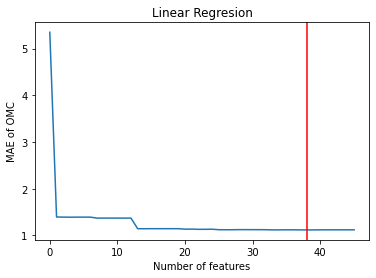

In [23]:
plt.plot(list(dane_do_porownania["Błąd"]))
plt.axvline(x=list(dane_do_porownania["Błąd"]).index(min(list(dane_do_porownania["Błąd"]))), color='r', linestyle='-')
plt.xlabel("Number of features")
plt.ylabel("MAE of OMC")
plt.title("Linear Regresion")
plt.show()

In [24]:
dane_do_porownania["Błąd"]

0     5.348865
1     1.393720
2     1.391624
3     1.389594
4     1.390901
5     1.391261
6     1.390935
7     1.369753
8     1.370721
9     1.370990
10    1.370847
11    1.369815
12    1.370557
13    1.142583
14    1.142659
15    1.143713
16    1.143468
17    1.143679
18    1.143679
19    1.143853
20    1.132910
21    1.134665
22    1.129949
23    1.130455
24    1.132244
25    1.121927
26    1.121074
27    1.121569
28    1.123341
29    1.123365
30    1.122732
31    1.122828
32    1.121679
33    1.117801
34    1.118867
35    1.120042
36    1.119598
37    1.118064
38    1.117390
39    1.117390
40    1.119136
41    1.119503
42    1.119674
43    1.119674
44    1.119674
45    1.119674
Name: Błąd, dtype: float64

In [25]:
kombinacje[38]

['CRj',
 'PI-PLOD',
 'ŁÓDZKIE',
 'WARMIŃSKO-MAZURSKIE',
 'ŚLĄSKIE',
 'LUBUSKIE',
 'MAŁOPOLSKIE',
 'kg bi',
 'IP',
 'kg tł',
 2021,
 'OPOLSKIE',
 'POMORSKIE',
 'PP',
 2017,
 2019,
 2020,
 2016,
 2018,
 'ŚWIĘTOKRZYSKIE',
 'w',
 'og',
 'Psm',
 'PI-PROD',
 'DOLNOŚLĄSKIE',
 '% bi',
 '% tł',
 'MAZOWIECKIE',
 'WIELKOPOLSKIE',
 'CRk',
 'Pw',
 'PI-POKR',
 'Pnr',
 'Prc',
 'KUJAWSKO-POMORSKIE',
 'ZACHODNIOPOMORSKIE',
 'nr',
 'sm',
 'WH-KSOM']

In [26]:
zestaw_caly=caly_df_zapas
zestaw_38=caly_df_zapas[kombinacje[38]]

zestaw_caly = np.array(zestaw_caly)
zestaw_38 = np.array(zestaw_38)

caly_label = np.array(caly_label)

In [27]:
caly_label

array([105,  98, 100, ..., 114, 128, 112], dtype=int64)

In [27]:
dane_do_porownania.to_csv('Wyniki REFCV Regresja liniowa OMC.csv',index=False)

In [28]:
zestaw_caly

array([[137., 127., 121., ...,   0.,   1.,   0.],
       [126., 123., 109., ...,   0.,   0.,   0.],
       [126., 120., 110., ...,   0.,   1.,   0.],
       ...,
       [120., 109., 106., ...,   1.,   0.,   0.],
       [113., 114.,  97., ...,   0.,   0.,   0.],
       [126., 117., 107., ...,   0.,   1.,   0.]])

In [29]:
zestaw_38

array([[107., 109.,   0., ..., 109., 114., 112.],
       [114., 114.,   0., ..., 104., 113., 118.],
       [112., 113.,   0., ..., 102., 103., 126.],
       ...,
       [114., 120.,   0., ...,  99., 101., 121.],
       [104., 114.,   1., ..., 111.,  97., 119.],
       [107., 110.,   0., ..., 117., 105., 118.]])

## 7 Cross validacja k=5

### 7.1 Wszystkie

In [30]:
kfold = KFold(n_splits=5, shuffle=False)
dane_do_zapisu_1=pd.DataFrame()
licznik=1
wart_1=[]
        
for train, test in kfold.split(zestaw_caly, caly_label):
    LR_1 = LinearRegression()
    LR_1.fit(zestaw_caly[train], caly_label[train])
    
    predykcje=LR_1.predict(zestaw_caly[test])
    dane_folda_1=pd.DataFrame({"pred": predykcje.ravel(),
                                "obs": caly_label[test],
                                "Fold":licznik})
    dane_do_zapisu_1=pd.concat([dane_do_zapisu_1,dane_folda_1])
    sredni_blad=mean_absolute_error(caly_label[test],predykcje)
    wart_1.append(sredni_blad)
    licznik+=1

In [31]:
wart_1

[1.1180597241500896,
 1.1341524517225197,
 1.0803519316248906,
 1.130801657247563,
 1.1350060432577593]

In [32]:
sum(wart_1)/len(wart_1)

1.1196743616005644

### 8.4.2 zestaw 38

In [33]:
kfold = KFold(n_splits=5, shuffle=False)
dane_do_zapisu_2=pd.DataFrame()
licznik=1
wart_2=[]

for train, test in kfold.split(zestaw_38, caly_label):
    LR_2 = LinearRegression()
    
    LR_2.fit(zestaw_38[train], caly_label[train])
    predykcje=LR_2.predict(zestaw_38[test])
    dane_folda_2=pd.DataFrame({"pred": predykcje.ravel(),
                                "obs": caly_label[test],
                                "Fold":licznik})
    dane_do_zapisu_2=pd.concat([dane_do_zapisu_2,dane_folda_2])
    sredni_blad=mean_absolute_error(caly_label[test],predykcje)
    wart_2.append(sredni_blad)
    licznik+=1

In [34]:
wart_2

[1.1168931626691387,
 1.1301087671382402,
 1.0750846671436445,
 1.1304681640566805,
 1.1343951476776724]

In [35]:
sum(wart_2)/len(wart_2)

1.1173899817370754

### 8.5 Zapisuje predykcje Zestaw 22

In [54]:
#dane_do_zapisu_2.to_csv("D:/STUDIA/ROK_II/Projekt/Predykcje_i błędy/Zestaw 2000/IE_GradientBoostingRegresor_FS.csv")